# CNN

## Construir modelo de CNN

In [126]:
# Importar las librerias y paquetes

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Rescaling, BatchNormalization, Activation


## Ajustar la CNN a las imagenes para entrenar

In [114]:
# Cargando imagenes para entrenamiento y para test

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

train =  tf.keras.preprocessing.image_dataset_from_directory(
    "dataset/training_set",
    seed=1337,
    image_size= (64, 64),
    batch_size= 32,
)

test = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset/test_set",
    seed = 1337,
    image_size = (64,64),
    batch_size = 32
)

Found 8000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


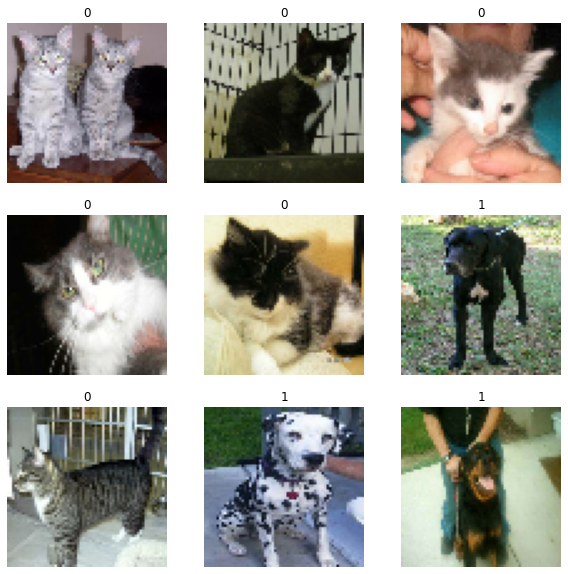

In [67]:
# Visualizando algunos datos

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [68]:
# Usando data augmentation

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

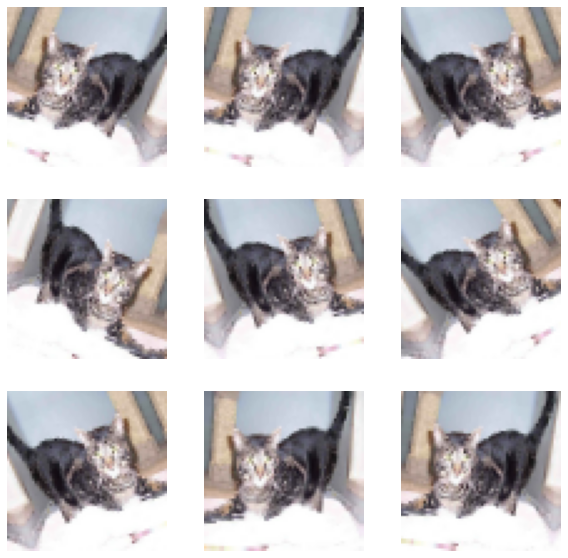

In [121]:
plt.figure(figsize=(10, 10))
for images, _ in train.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [134]:
augmented_train = train.map(
  lambda x, y: (data_augmentation(x, training=True), y))


In [147]:
image_size = (64,64)
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)


In [148]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train, epochs=epochs, callbacks=callbacks, validation_data=test,
)

Epoch 1/50
250/250 [==============================] - ETA: 0s - loss: 0.6604 - accuracy: 0.6273

C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


250/250 [==============================] - 193s 757ms/step - loss: 0.6604 - accuracy: 0.6273 - val_loss: 0.7847 - val_accuracy: 0.5000
Epoch 2/50
250/250 [==============================] - 185s 741ms/step - loss: 0.5893 - accuracy: 0.6971 - val_loss: 0.8232 - val_accuracy: 0.5030
Epoch 3/50
250/250 [==============================] - 201s 804ms/step - loss: 0.5444 - accuracy: 0.7329 - val_loss: 0.5196 - val_accuracy: 0.7505
Epoch 4/50
250/250 [==============================] - 203s 814ms/step - loss: 0.5093 - accuracy: 0.7549 - val_loss: 0.5360 - val_accuracy: 0.7505
Epoch 5/50
250/250 [==============================] - 196s 784ms/step - loss: 0.4670 - accuracy: 0.7796 - val_loss: 0.9174 - val_accuracy: 0.6175
Epoch 6/50
250/250 [==============================] - 191s 764ms/step - loss: 0.4407 - accuracy: 0.7989 - val_loss: 0.5093 - val_accuracy: 0.7780
Epoch 7/50
250/250 [==============================] - 203s 811ms/step - loss: 0.4125 - accuracy: 0.8144 - val_loss: 0.4127 - val_accura

In [149]:
img = keras.preprocessing.image.load_img(
    "dataset/single_prediction/coco.jpg", target_size=(64,64)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = classifier.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

This image is 23.79 percent cat and 76.21 percent dog.


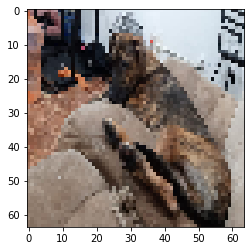

In [150]:
plt.imshow(img_array[0].numpy().astype("uint8"))